In [324]:
import os
from matplotlib.pyplot import imread
#some important defines for rest of project
celeb_height = 218
celeb_width = 178
celeb_depth = 3

# specifiy the CelebA folder
dirname = "./Data/img_align_celeba/img_align_celeba"

files = [filename for (dirpath, dirnames, filenames) in os.walk(dirname)
                  for filename in filenames if filename[-4:] == ".jpg"]

if len(files) == 0:
    print ("ERROR: wrong folder")
    import sys  
    sys.exit(1)
    
print('Total number of celebA images is : ', len(files))
print('First 10 files are:')
for i, filename in enumerate(files):
    if i < 10:
         print(filename)

Total number of celebA images is :  202599
First 10 files are:
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg


# Look at some test images

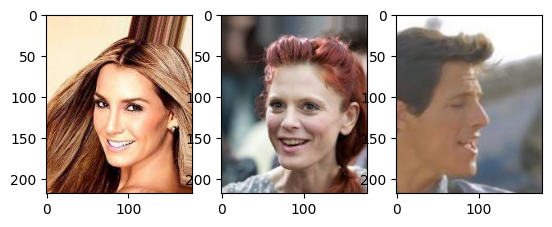

In [325]:
from skimage import io
import matplotlib.pyplot as plt

face1 = io.imread(dirname+"/"+files[0])
face2 = io.imread(dirname+"/"+files[1])
face3 = io.imread(dirname+"/"+files[2])

plt.subplot(1, 3, 1)
plt.imshow(face1)
plt.subplot(1, 3, 2)
plt.imshow(face2)
plt.subplot(1, 3, 3)
plt.imshow(face3)

# Step 1: Read in Image Data as Tensor
The numpy array is great, but we would prefer to user tensors. Note we need the dtype of the tensor to be a float so we can support the later operations, but to save space on the operation of reading the imgaes in, we only use a uint8.Also, the grayscale version of each image tends to yield better results
 


To speed up results even further, we will run operations using CUDA cores. Here we can check to see what is available 

In [326]:
import torch 
print(torch.cuda.is_available())
cpu = torch.device("cpu")
cuda = torch.device("cuda:0") 

torch.cuda.empty_cache()
device = cpu #cpu

True


In [327]:
%%time
import torch 
import imageio.v3 as iio
import numpy as np
total_number_of_faces = 100

dimx, dimy = int(218), int(178)

def rgb2gray(image):
    img_gray = np.zeros((218, 178, 3), dtype = np.uint8)
    return np.stack([np.dot(image, [.333,.333,.333])]*3, axis=-1)
  
tensor_data = torch.zeros(total_number_of_faces, dimx*dimy*3, dtype=torch.uint8, device=device)

for index, filename in enumerate(files):
    if index == total_number_of_faces:
        break
    tensor_data[index] = torch.tensor(((rgb2gray(iio.imread(dirname+"/"+filename)).flatten().ravel())),  device=device)

CPU times: total: 1.72 s
Wall time: 167 ms


The shape of each element is 217\*178\*3, the full size of each image.
The shape of data is a 2D array with the first number indicating the number of pictures and the second the size of each (in the collapsed form above)

In [328]:
print("single image tensor:", tensor_data[0].shape)
print("image data tensor:", tensor_data.shape)

single image tensor: torch.Size([116412])
image data tensor: torch.Size([100, 116412])


In [329]:
tensor_data

tensor([[225, 225, 225,  ...,  64,  64,  64],
        [ 54,  54,  54,  ..., 123, 123, 123],
        [254, 254, 254,  ...,  94,  94,  94],
        ...,
        [138, 138, 138,  ..., 207, 207, 207],
        [122, 122, 122,  ...,  36,  36,  36],
        [ 56,  56,  56,  ...,  34,  34,  34]], dtype=torch.uint8)

# Step 2: Preprocess Data
Now we want to perform Principal Componant Analysis on the data. This helps with centering and to pull out the principal componants

In [343]:
%%time
U,S,V = torch.pca_lowrank(tensor_data.double(), q=total_number_of_faces, center=True, niter=2)

prin_comp = 10000
preprocessed_data_temp = torch.matmul(tensor_data.double().T, V.T[:, :prin_comp])

preprocessed_data_temp.shape


CPU times: total: 43.2 s
Wall time: 4.58 s


torch.Size([116412, 10000])

 The relation of (U, S, V) to PCA is as follows:

A is a data matrix with m samples and n features

the V columns represent the principal directions

S ** 2 / (m - 1) contains the eigenvalues of A.T * A / (m - 1)
which is the covariance of A when center=True is provided.

matmul(A, V[:, :k]) projects data to the first k principal components

We can reproduce the image by projecting the PCA result back into its original dimensions. We need to also convert the data back into integer form.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 116412])

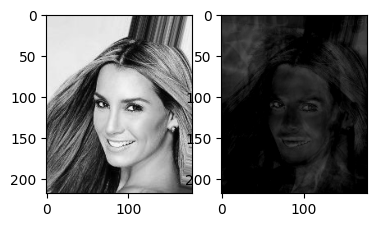

In [344]:
preprocessed_data  = torch.matmul(V.T[:, :prin_comp], preprocessed_data_temp.T).int()

#use .cpu() to convert to cpu so numpy can reshape and then matplot can show
plt.subplot(1, 3, 1)
if tensor_data.is_cuda:
    plt.imshow(tensor_data[0].cpu().reshape(celeb_height,celeb_width,celeb_depth))
    plt.subplot(1, 3, 2)
    plt.imshow(preprocessed_data[0].cpu().reshape(celeb_height,celeb_width,celeb_depth))
else:
    plt.imshow(tensor_data[0].reshape(celeb_height,celeb_width,celeb_depth))
    plt.subplot(1, 3, 2)
    plt.imshow(preprocessed_data[0].reshape(celeb_height,celeb_width,celeb_depth))

preprocessed_data.shape

# Step 3: Compute Average Face Vector
Now the data is preprocessed, we follow the steps to compute the Eigan faces. First we need to compute the average face.

CPU times: total: 328 ms
Wall time: 36.7 ms


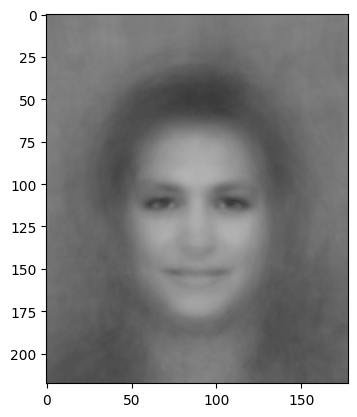

In [345]:
%%time
import pandas as pd

face_loader = torch.utils.data.DataLoader(tensor_data, batch_size=10000, shuffle=False)

mean_face = torch.zeros(celeb_height*celeb_width*celeb_depth, dtype=torch.float32, device=device)

for faces in face_loader:   
        faces = faces.type(torch.float32)
        mean_face += (faces.sum(0)) / (1.0 * total_number_of_faces)
        
if tensor_data.is_cuda:
        plt.imshow((mean_face.type(torch.uint8)).cpu().reshape(218, 178, 3))
else:
        plt.imshow((mean_face.type(torch.uint8)).reshape(218, 178, 3))

# Step 4: Subtract the mean face

CPU times: total: 156 ms
Wall time: 23.8 ms


torch.Size([100, 116412])

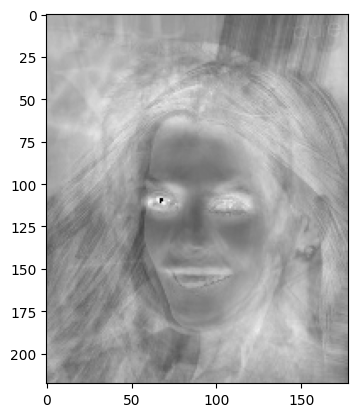

In [346]:
%%time
mean_face_removed = torch.zeros(total_number_of_faces, dimx*dimy*3, dtype=torch.uint8, device=device)

for index, filename in enumerate(files):
    if index == total_number_of_faces:
        break
    mean_face_removed[index] = torch.subtract(preprocessed_data[index], mean_face, alpha=1)

plt.imshow((mean_face_removed[0].cpu().type(torch.uint8)).reshape(218, 178, 3))
mean_face_removed.shape

# Step 5: Compute the Covariance Matrix
We'll actually use a shortcut, but this is simple to compute so I added here

In [347]:
%%time
cov_data = torch.cov(mean_face_removed, correction=1)

cov_data

CPU times: total: 641 ms
Wall time: 74.4 ms


tensor([[ 750.2388,  -50.2002,  323.4803,  ...,  276.3823,  211.3539,
          216.9195],
        [ -50.2002, 1274.1108,  716.4438,  ...,  679.6525,  716.3854,
          720.8259],
        [ 323.4803,  716.4438,  582.4256,  ...,  523.4472,  500.7369,
          512.1132],
        ...,
        [ 276.3823,  679.6525,  523.4472,  ...,  496.5069,  490.4736,
          480.4491],
        [ 211.3539,  716.3855,  500.7368,  ...,  490.4736,  513.8396,
          495.9828],
        [ 216.9195,  720.8258,  512.1131,  ...,  480.4491,  495.9828,
          533.1573]])

# Step 6: Compute the Eigen Vectors


In [348]:
%%time
# automatically normalizes to 1
small_cov = torch.matmul(mean_face_removed.double(), mean_face_removed.double().T)

print("shape:",small_cov.shape)

eigen_val, eigen_vec = torch.linalg.eig(small_cov)

eigen_vec

shape: torch.Size([100, 100])
CPU times: total: 781 ms
Wall time: 75.4 ms


tensor([[-1.0574e-01+0.j, -4.4877e-01+0.j, -7.6759e-02+0.j,  ...,
         -3.0254e-04+0.j, -1.8961e-04+0.j, -1.3188e-04+0.j],
        [-9.0291e-02+0.j,  3.4919e-01+0.j,  1.3557e-01+0.j,  ...,
         -1.9390e-01+0.j, -1.8237e-01+0.j,  1.6034e-03+0.j],
        [-9.5091e-02+0.j, -6.7475e-03+0.j,  1.1343e-01+0.j,  ...,
          1.5321e-02+0.j,  1.4855e-01+0.j,  2.2984e-01+0.j],
        ...,
        [-1.0104e-01+0.j, -1.1624e-02+0.j,  2.4401e-02+0.j,  ...,
          2.8372e-02+0.j, -1.1519e-01+0.j, -5.8644e-02+0.j],
        [-1.0077e-01+0.j,  4.2791e-02+0.j, -5.4217e-02+0.j,  ...,
          5.0354e-02+0.j,  1.3404e-02+0.j,  1.3719e-01+0.j],
        [-1.0157e-01+0.j,  4.9329e-02+0.j, -4.0372e-02+0.j,  ...,
         -1.2883e-03+0.j,  2.4837e-03+0.j, -2.3772e-03+0.j]],
       dtype=torch.complex128)

# Step 7: Keep only the Best K Vectors

In [360]:
%%time
#number of k -largest to keep
best_k_vectors = 7   
import numpy as np

np_eigen_vals = np.array(eigen_val.cpu())
np_eigen_vals_abs = np.zeros(len(np_eigen_vals))

#find the largest magnitude of the eigen values for each vector
for i in range(len(np_eigen_vals)):
    np_eigen_vals_abs[i] = np.absolute(np_eigen_vals[i])

#find the top k indicies of each eigen vector with maximal value
indicies = np.argpartition(np_eigen_vals_abs, -best_k_vectors)[-best_k_vectors:]

best_vectors = [eigen_vec[index].double() for index in indicies]
# #convert A^TA vectors to A^TA vectors
for j in range(len(best_vectors)):
    best_vectors[j] = torch.matmul(mean_face_removed.double().T, best_vectors[j])

eigen_sum = np.array([np_eigen_vals_abs[index] for index in indicies]).sum()


CPU times: total: 2.34 s
Wall time: 232 ms


# Step 8: Use the eigen vectors to contruct eigen faces

Each face (minus the mean) can be contructed from the eigen vectores calculated earlier. Only a few are shown here

In [361]:
%%time
eigen_faces_celebA = torch.zeros(total_number_of_faces, best_k_vectors, dimx*dimy*3, dtype=torch.float32, device=device)

for index, filename in enumerate(files):
    if index == total_number_of_faces:
        break
    eigen_faces_index = torch.zeros(best_k_vectors, dimx*dimy*3, dtype=torch.float32, device=device)
    for i in range(0, best_k_vectors-1):
        eigen_faces_index[i] = torch.mul(mean_face_removed[i], best_vectors[i+1])*(np_eigen_vals_abs[i+1]/eigen_sum)
    eigen_faces_celebA[index] = eigen_faces_index

print(eigen_faces_celebA.shape)

torch.Size([100, 7, 116412])
CPU times: total: 4.23 s
Wall time: 422 ms


Now we can show the results:

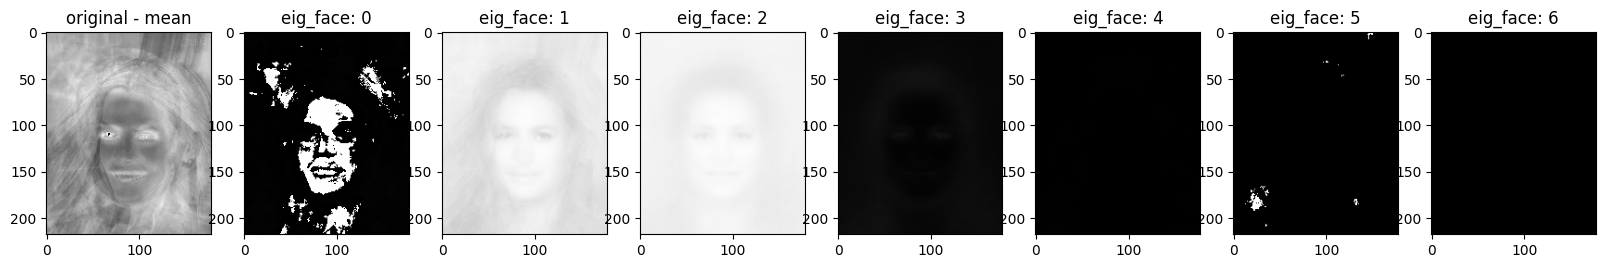

In [362]:
cols = best_k_vectors+1
fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20, 20))
plt.subplot(1, cols, 1)
plt.title("original - mean")
plt.imshow((mean_face_removed[0].cpu().type(torch.uint8)).reshape(218, 178, 3))

eig_face_sum = 0
for i in range(0, best_k_vectors):
    plt.subplot(1, best_k_vectors+1, i+2)
    plt.title("eig_face: " + str(i))
    plt.imshow((eigen_faces_celebA[0][i].cpu().type(torch.uint8)).reshape(218, 178, 3))
    eig_face_sum += eigen_faces_celebA[0][i]